## Writing a fieldfile for OF from a given mesh

In [61]:
import matplotlib.pyplot as plt
import numpy as np

import warnings
import os
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.interpolate import interpn

from cfdnetplus.VTKlatestTime import VTKlatestTime


import meshio
import re

In [62]:
mainfolder='airfoil2d/airFoil_500'
fields= ['U','p','k','omega','nut']

xlim =[-50,50]
ylim = [-40 , 40]


folder_pred=mainfolder+'/pred.npy'
pred=np.load(folder_pred)

[a,y_steps, x_steps,layers]=pred.shape


In [63]:
x = np.arange(xlim[0],xlim[1], (xlim[1]-xlim[0])/x_steps)
y = np.arange(ylim[0],ylim[1], (ylim[1]-ylim[0])/y_steps)

a,ts =VTKlatestTime(mainfolder)

path2folder=mainfolder+'/'+str(0)
path2dst=mainfolder+'/'+str(ts+1)

print(path2dst)
if os.path.isdir(path2dst)==False:
    os.mkdir(path2dst)

folders=os.listdir(path2dst)

airFoil_500_0
airFoil_500_20
airfoil2d/airFoil_500/21


In [64]:
main_split=mainfolder.split('/')
mainfolder_mesh=mainfolder+'/VTK/'+main_split[1]+'_'+str(ts)+'/internal.vtu'
print(main_split[0]+main_split[1])
print(mainfolder_mesh)

airfoil2dairFoil_500
airfoil2d/airFoil_500/VTK/airFoil_500_20/internal.vtu


In [65]:
# loads the mesh and splits all relevant info into seperate variables
mesh=meshio.read(mainfolder_mesh)

cell_ptsid=mesh.cells_dict

#what happens if the mesh is not only hexahedron?
cell_ptsid=np.array(cell_ptsid['hexahedron'])

points = mesh.points

In [66]:
print(mesh.cell_data['U'])
U_orig=np.array(mesh.cell_data['U'])[0,3]
print(U_orig)

[array([[ 6.72225e+01, -1.18041e+02, -2.26332e-15],
       [ 6.34669e+01, -6.74908e+01,  3.65606e-15],
       [ 6.42274e+01, -1.84150e+01,  0.00000e+00],
       ...,
       [ 5.00816e+02,  1.80771e-01,  0.00000e+00],
       [ 5.00807e+02,  9.16491e-02, -7.16185e-18],
       [ 5.00734e+02,  5.30108e-02,  0.00000e+00]], dtype=float32)]
[6.79841e+01 2.50158e+01 4.14403e-14]


In [67]:
cell_pts=points[cell_ptsid[:,:]]

centroids=np.average(cell_pts,axis=1)

## Export to Openfoam

airfoil2d/airFoil_500/21/U
0
1
2
(1, 10720, 3)
10720
airfoil2d/airFoil_500/21/p
airfoil2d/airFoil_500/21/k
airfoil2d/airFoil_500/21/omega
airfoil2d/airFoil_500/21/nut


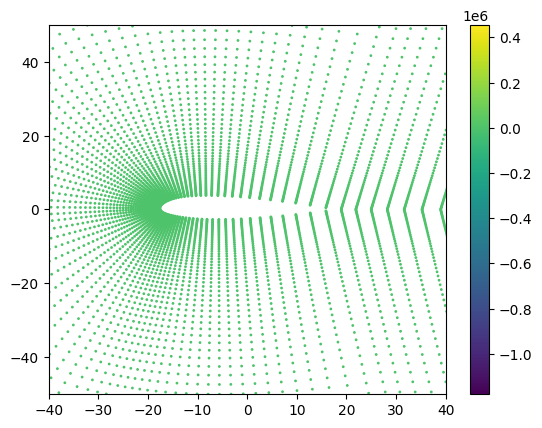

In [72]:
i=0
for field in fields:
    print(path2dst+'/'+field)
    with open(path2folder+'/'+field,"r") as f:
        contents=f.readlines()
    idx = [j for j, item in enumerate(contents) if re.search('internalField   ', item)]
    
    if field == 'U':
        U=np.empty((1,centroids.shape[0],0))
        for it in range(3):
            print(it)
            znew=[]
            znew.append( interpolate.interpn((x, y) , np.transpose(pred[:,:,:,i]), centroids[:,0:2],
                                 bounds_error=False,
                                 method='linear',
                                 fill_value=None,
                                ))
            znew=np.array(znew)
            U=np.concatenate((U,znew),axis=2)
        print(U.shape)
        #iterates through the vertices and saves the corresponding values
        string=''
        print(centroids.shape[0])
        for j in range(centroids.shape[0]):
            #print(centroids[j])
            if centroids[j,0] > xlim[0] and centroids[j,0] < xlim[1] and centroids[j,1] > ylim[0] and centroids[j,1] < ylim[1]:
                #print('in')
                string = string +'('+ str(U[0,j,0]) + ' '+str(U[0,j,1])+ ' '+ str(U[0,j,2])+')''\n'
            else:
                string = string +'('+str(np.array(mesh.cell_data[field])[0,j,0])+ ' '+str(np.array(mesh.cell_data[field])[0,j,1])+ ' '+str(np.array(mesh.cell_data[field])[0,j,2])+')''\n'
        # creates a complete list will all lines that need to be written in the field file
        contents[idx[0]]='internalField   nonuniform List<vector>'+'\n'+str(np.array(centroids).shape[0])+'\n'+'('+string+');'
        
        plt.scatter(centroids[:,0],centroids[:,1], c=U[0,:,0], s=1)
        plt.colorbar()
        plt.xlim([-40,40])
        plt.ylim([-50,50])
    else:
        znew=[]
        znew.append( interpolate.interpn((x, y) , np.transpose(pred[:,:,:,i+2]), centroids[:,0:2],
                                 bounds_error=False,
                                 method='linear',
                                 fill_value=None,
                                ))
        znew=np.array(znew)
        
        #iterates through the vertices and saves the corresponding values
        string=''
        for j in range(centroids.shape[0]):
            if centroids[j,0] > xlim[0] and centroids[j,0] < xlim[1] and centroids[j,1] > ylim[0] and centroids[j,1] < ylim[1]:
                #center inside of pred-domain use pred values
                string = string + str(znew[0,j,0]) + '\n'
            else:
                #center outside of pred-domain use input values
                string = string + str(np.array(mesh.cell_data[field])[0,j]) + '\n'
        
        # creates a complete list will all lines that need to be written in the field file
        contents[idx[0]]='internalField   nonuniform List<scalar>'+'\n'+str(np.array(centroids).shape[0])+'\n'+'('+string+');'
        
    with open(path2dst+'/'+field,"w") as f:
        f.writelines(contents)
    i=i+1

In [74]:
np.load('cfdnetplus_models/model3/dims.npy')

array([ 2.56e+02,  6.60e+01, -5.00e+01,  5.00e+01, -4.00e+01,  4.00e+01,
        5.00e-02])